In [1]:
import os
import json
import cv2
from matplotlib import pyplot as plt
from tqdm.auto import tqdm
from IPython.display import Video, HTML
from ipywidgets import interact, widgets

cap = None

ModuleNotFoundError: No module named 'ipywidgets'

In [ ]:
with open('../data/mouse_video/annotation.json', 'r') as f:
    annot = json.load(f)
video_paths = [(a['video_path'], a['cage']) for a in annot]

In [ ]:
annot

In [ ]:
# for vid_annot in annot:
vid_annot = annot[0]
path = f"../{vid_annot['cropped_path']}"
fps = vid_annot['fps']
show_annot = vid_annot['annotation'][1]
show_annot = [t * fps if vid_annot.get('unit', 'sec') == 'sec' else t for t in show_annot]


if cap is not None:
    cap.release()
    cap = None
cap = cv2.VideoCapture(path)
cap.set(cv2.CAP_PROP_POS_FRAMES, show_annot[0])
frames = {}
for i in range(show_annot[0], show_annot[1] + 1):
    ret, frame = cap.read()
    if not ret:
        print(f'error on frame {i}')
        continue
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    frames[i] = frame

def show_frame(frame_idx):
    frame = frames[frame_idx]
    plt.figure(figsize=(16, 9))
    plt.imshow(frame)
    plt.show()

interact(show_frame, frame_idx=widgets.IntSlider(min=show_annot[0], max=show_annot[1], value=0))

In [2]:
%cd /home/donny/video_classification

/home/donny/video_classification


In [3]:
import random
import torchvision
from action_recognition.datasets import MouseClipDataset
import logging
logging.basicConfig(level="INFO")

In [4]:
ds = MouseClipDataset.from_ds_folder(
    './data/mouse_video/crop_preprocessed',
    './data/mouse_video/crop_preprocessed/metadata.pth',
    extract_groom=True,
    output_type='random_frame',
    frames_per_clip=1,
    step_between_clips=1,
    num_sample_per_clip=1,
    frame_rate=None
)
# ).get_split('./data/mouse_video/crop_preprocessed', 'valid', 'random', {})
ds.transform = None

INFO:action_recognition.datasets.baseline_dataset:class2idx: {'groom': 0, 'not_groom': 1}
INFO:action_recognition.datasets.baseline_dataset:Extracted groom video count: 891
INFO:action_recognition.datasets.baseline_dataset:frame_distribution: min 2, max 39746
INFO:action_recognition.datasets.baseline_dataset:dataset length: 498360
INFO:action_recognition.datasets.baseline_dataset:video count: 1042
INFO:action_recognition.datasets.baseline_dataset:class distribution: {0: 15401, 1: 482959}


In [5]:
ds = MouseClipDataset.from_annotation_list(
    './data/breakfast',
    output_type='video',
    frames_per_clip=32,
    step_between_clips=1,
    num_sample_per_clip=1,
    frame_rate=None
).get_split('./data/breakfast', 'valid', 'cv_0', {})
ds.transform = None

In [8]:
label = -1
while label <= 0:
    idx = random.randint(0, len(ds))
    video_idx, _ = ds.video_clips.get_clip_location(idx)
    label = ds.labels[video_idx]
print()
video, label, video_idx = ds[idx]
print(label)
print(ds.video_clips.video_paths[video_idx])

out_fn = './output/test.mp4'
torchvision.io.write_video(out_fn, video, fps=30)
Video(out_fn)


14
./data/breakfast/BreakfastII_15fps_qvga_sync/P23/webcam01/P23_salat.avi


In [5]:
lens = [len(pts) for pts, lab in zip(ds.video_clips.video_pts, ds.labels) if lab == 0]

(array([  1.,   3.,   0.,   1.,   4.,   6.,   9.,   6.,  14.,  18.,  42.,
         62., 101.,  95., 100.,  92.,  67.,  55.,  41.,  34.,  32.,  16.,
         16.,  12.,  11.,  13.,  11.,   1.,   6.,   4.,   0.,   3.,   3.,
          1.,   3.,   0.,   1.,   0.,   2.,   0.,   0.,   1.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   2.,   0.,   0.,
          0.,   1.]),
 array([ 2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14.,
        15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26., 27.,
        28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38., 39., 40.,
        41., 42., 43., 44., 45., 46., 47., 48., 49., 50., 51., 52., 53.,
        54., 55., 56., 57., 58., 59.]),
 <a list of 57 Patch objects>)

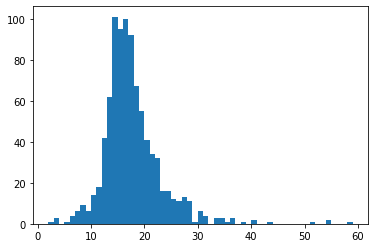

In [12]:
lens2 = [l for l in lens if 20 >= l]
lens2 = lens

plt.hist(lens2, bins=max(lens2)-min(lens2))

In [14]:
ds[random.randint(0, len(ds)-1)][0].size()

torch.Size([32, 1080, 850, 3])

In [15]:
ds_labels = []
for idx in range(len(ds)):
    video_idx, _ = ds.video_clips.get_clip_location(idx)
    label = ds.labels[video_idx]
    ds_labels.append(label)

In [22]:
from collections import Counter
Counter(ds_labels)

Counter({0: 165, 1: 478278})

In [5]:
ds_train = ds.get_split('./data/mouse_video/crop_preprocessed', 'train', 'cage_valid', {})

INFO:action_recognition.datasets.baseline_dataset:frame_distribution: min 3, max 11099
INFO:action_recognition.datasets.baseline_dataset:dataset length: 225775
INFO:action_recognition.datasets.baseline_dataset:video count: 574
INFO:action_recognition.datasets.baseline_dataset:class distribution: {0: 7974, 1: 217801}


In [59]:
from torchvision import transforms
from action_recognition.datasets.augmentation import default_transformation_2D
ds_train.transform = transforms.Compose(default_transformation_2D['train'].transforms.copy())
ds_train.transform.transforms[2] = transforms.RandomRotation(0, expand=True)
ds_train.transform.transforms = ds_train.transform.transforms[:-1]

In [34]:
ds_train.transform

Compose(
    ToPILImage()
    RandomHorizontalFlip(p=0.5)
    RandomRotation(degrees=(-180, 180), resample=False, expand=True)
    Resize(size=224, interpolation=PIL.Image.BILINEAR)
    RandomCrop(size=(224, 224), padding=None)
    ToTensor()
)

Text(0.5, 1.0, '0')

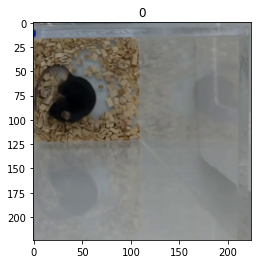

In [67]:
label = -1
while label != 0:
    idx = random.randint(0, len(ds_train))
    video_idx, _ = ds_train.video_clips.get_clip_location(idx)
    label = ds_train.labels[video_idx]

random_sample, label, video_idx = ds_train[idx]
plt.imshow(random_sample.permute(1, 2, 0))
plt.title(label)